In [2]:
import os 
import glob
import pandas as pd
import numpy as np
import seaborn as sns
import timeit
import random
import matplotlib.pyplot as plt
import datetime
from datetime import date
from datetime import datetime
import time

import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_curve, auc
from sklearn.base import TransformerMixin
from sklearn.utils import resample

import warnings
# We can ignore warnings only on final run-through to improve legibility.
# warnings.filterwarnings('ignore')

<br/>

## I. READ DATA & PROFILE
Bring in a relevant representative sample 
knowing we can always add more data to improve model + analytics.

In [3]:
df1 = pd.read_csv(r"cancellations/flight_2015_1.csv")
df2 = pd.read_csv(r"cancellations/flight_2015_2.csv")
df3 = pd.read_csv(r"cancellations/flight_2015_5.csv")
df4 = pd.read_csv(r"cancellations/flight_2015_8.csv")

/Users/Tanner/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (77,84,85) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/Tanner/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (77,84) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/Tanner/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (48,77,84) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
df1b.to_csv(r"cancellations/flight_2015_1.csv")
df2b.to_csv(r"cancellations/flight_2015_2.csv")
df3b.to_csv(r"cancellations/flight_2015_5.csv")
df4b.to_csv(r"cancellations/flight_2015_8.csv")

#### Concatenate datasets:

In [57]:
# df2.head()
# cols = df2.columns
# print(cols)
dflist = [df1,df2,df3,df4]
flight_data = pd.concat(dflist,axis=0)

#### Check shapes:

In [58]:
print(flight_data.shape)
print(df1.shape)
print(df2.shape)
print(df3.shape)
print(df4.shape)

(1906688, 112)
(469968, 112)
(429191, 112)
(496993, 112)
(510536, 112)


#### Create disruption flag if delay is >= 240 minutes or canceled:


In [6]:
def disruption(x):
    if x >= 240: 
        return 1
    else: 
        return 0

df1['delay_flag'] = df1['DepDelayMinutes'].apply(disruption)
df2['delay_flag'] = df2['DepDelayMinutes'].apply(disruption)
df3['delay_flag'] = df3['DepDelayMinutes'].apply(disruption)
df4['delay_flag'] = df4['DepDelayMinutes'].apply(disruption)
flight_data['delay_flag'] = flight_data['DepDelayMinutes'].apply(disruption)

df1['disruption_flag'] = df1[['delay_flag','Cancelled']].max(axis=1)
df2['disruption_flag'] = df2[['delay_flag','Cancelled']].max(axis=1)
df3['disruption_flag'] = df3[['delay_flag','Cancelled']].max(axis=1)
df4['disruption_flag'] = df4[['delay_flag','Cancelled']].max(axis=1)
flight_data['disruption_flag'] = flight_data[['delay_flag','Cancelled']].max(axis=1)

#### Check disruption flags by month and in aggregate:
Given four months of 2015 data, "disruptions" occur in about 2.65% of all flights. 
This dataset may be slightly imbalanced for modeling and could benefit from over- or under-sampling techniques, such as SMOTE.


In [7]:
print("df1",df1['disruption_flag'].value_counts())
print(df1['disruption_flag'].value_counts(normalize=True))
print("df2",df2['disruption_flag'].value_counts())
print(df2['disruption_flag'].value_counts(normalize=True))
print("df3",df3['disruption_flag'].value_counts())
print(df3['disruption_flag'].value_counts(normalize=True))
print("df4",df4['disruption_flag'].value_counts())
print(df4['disruption_flag'].value_counts(normalize=True))

print('\n',"all flight data",flight_data['disruption_flag'].value_counts())
print(flight_data['disruption_flag'].value_counts(normalize=True))


# Perform a box and whisker disruption for further look at distribution.


df1 0.0    456424
1.0     13544
Name: disruption_flag, dtype: int64
0.0    0.971181
1.0    0.028819
Name: disruption_flag, dtype: float64
df2 0.0    406933
1.0     22258
Name: disruption_flag, dtype: int64
0.0    0.94814
1.0    0.05186
Name: disruption_flag, dtype: float64
df3 0.0    489237
1.0      7756
Name: disruption_flag, dtype: int64
0.0    0.984394
1.0    0.015606
Name: disruption_flag, dtype: float64
df4 0.0    503639
1.0      6897
Name: disruption_flag, dtype: int64
0.0    0.986491
1.0    0.013509
Name: disruption_flag, dtype: float64

 all flight data 0.0    1856233
1.0      50455
Name: disruption_flag, dtype: int64
0.0    0.973538
1.0    0.026462
Name: disruption_flag, dtype: float64


#### Add weekend flag:


In [8]:
def weekend(x):
    if x >= 6:
        return 1
    else: 
        
        return 0
    
flight_data['weekend_flag'] = flight_data['DayOfWeek'].apply(weekend) 
flight_data['weekend_flag'].head()

0    0
1    0
2    1
3    1
4    0
Name: weekend_flag, dtype: int64

#### Convert CRSDepTime into cyclical continuous feature:


In [9]:
CRSDepTime = pd.DataFrame(flight_data['CRSDepTime'])

# CRSDepTime[0:6]
# normalize data first 
flight_data['sin_CRSDepTime'] = CRSDepTime.apply(lambda x: np.sin(x))
flight_data['sin_CRSDepTime'].sample(10)

flight_data['sin_CRSDepTime'].isnull().sum()


0

<br/>

## II. STRATEGY DISCUSSION / NOTES (post-EDA)

#### Pre-model: Revenue, Costs, and Profit 
#### Revenue per flight: 19 dollars (risk unknown)
#### Cost per disruption: 500 dollars (avg ticket price, see Ticket Price Assumption below)
#### Disruption Probability Constant: 2.5%    (*based on select months from 2015)
#### Expected revenue per disruption: = (19 / 0.025) = 760
#### Marginal profit per disruption: = 760 - 500 = 260

(at 1.9m flights in 4 months * 3 4-month periods we have 5.7 million BTS flights in 2015)
<br/> <br/>


### Features Brainstorm:
Hypothetical data (very few columns)
     1. Airport Origin ID
             could group into regions and number of flights
     2. Airport Destination ID
             could group into regions and number of flights
     3. Airline Carrer
     4. Month (and quarter)
     5. Day of the month (and week)
     6. Time of day (use radians or leave?)
     7. Pull in distance data between all airports from other .csvs
     8. Flight number (likely biased, but im sure it has a trend)


### Relevant Columns:
 disruption_flag, delay_flag, Cancelled
 Year, Quarter, Month, DayOfMonth, DayOfWeek,
 UniqueCarrier or Carrier?
 Origin, Dest (matches hypo data)
 DeptTime and CRSDepTime, CRSEstimatedTime (CRS is rounded, useful for var. reduction)
 Distance, DistanceGroup, AirTime (lagging?), ActualElapsedTime (lagging?) 
 (DistanceGroup useful as var. reduction)
 FlightNum

### Weather:
 Unless we have a current weather feed (or lagged by days, weeks months) its not easy to use this.
 However, one exception is a Farmer's Almanac-style YoY prediction for bad winters, natural disasters, etc.

### General Comments:
Develop a pricing system that takes the risk of the flight into account
explore what effect your hypothetical system would have on: <br/>
     -Revenue <br/>
     -Costs <br/>
     -Profits <br/>

#### 1. Build Model to predict flight disruptions (binary target?)
 -Encode binary disruption flag. <br/>
 -Build gbm, rf, or linear model in scikit learn.

#### 2. Create a marginal profit/loss column based on 19 dollar price
  Create a marginal profit/loss column based on three-tier pricing.

#### 3. Run bootstrapping to generate distribution of total profit/loss

### Ticket Price Assumption:
  500 dollar average ticket price for replacement cost of flights.
  If time, I could calculate distance between airports and build a simple linear model with floor and ceiling?
  I could also take into account # of stops (direct vs. non-direct).
  
  <br/>

## III. MODEL BUILD

#### Count Variable Levels:

#### Create BTS flight subset to model:

In [10]:
# flight_data.iloc[,20:40].head()
print(flight_data.shape)
# sample_length = len(flight_data)
sample_length = 1000000
random.seed(999)
flight_subset = flight_data.loc[:,['UniqueCarrier','Carrier','Origin','Dest','FlightNum'
                  ,'Year','Quarter','Month','DayofMonth','DayOfWeek'
                  ,'DepTime','CRSDepTime','sin_CRSDepTime','weekend_flag'
                  ,'CRSElapsedTime','Distance','DistanceGroup'
                  ,'AirTime','ActualElapsedTime'
                  ,'Cancelled','delay_flag','disruption_flag']].sample(sample_length,random_state=999)

print(flight_subset.shape)

(1906688, 114)
(1000000, 22)


In [11]:
for column in flight_subset:
    print(column,len(set(flight_subset[column])))

UniqueCarrier 14
Carrier 14
Origin 322
Dest 322
FlightNum 6547
Year 1
Quarter 3
Month 4
DayofMonth 31
DayOfWeek 7
DepTime 23234
CRSDepTime 1256
sin_CRSDepTime 1256
weekend_flag 2
CRSElapsedTime 498
Distance 1322
DistanceGroup 11
AirTime 25911
ActualElapsedTime 25947
Cancelled 2
delay_flag 2
disruption_flag 2


#### Impute function:

In [12]:
class DataFrameImputer(TransformerMixin):

    def __init__(self):
        """Impute missing values--
         dtype objects imputed with the most frequent value 
         other types are imputed with mean 
        """
    def fit(self, X, y=None):

        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].mean() for c in X],
            index=X.columns)

        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)

data = [
    ['a', 1, 2],
    ['b', 1, 1],
    ['b', 2, 2],
    [np.nan, np.nan, np.nan]
]


#### Subset features and split train vs. test datasets:

In [13]:
features = ['Carrier','Quarter','Month','DayOfWeek','DistanceGroup','CRSElapsedTime'
            ,'Origin','Dest','FlightNum'
           ,'Distance','CRSDepTime','weekend_flag'
#             ,'sin_CRSDepTime'
            ,'disruption_flag']

flight_subset_features = flight_subset[features]

random.seed(999)
flight_subset_features['random'] = [random.random() for i in range(len(flight_subset))]

flight_subset_features_impute = DataFrameImputer().fit_transform(flight_subset_features)

flight_train = flight_subset_features_impute.loc[flight_subset_features_impute['random'] < .75,:]
flight_test = flight_subset_features_impute.loc[flight_subset_features_impute['random'] >= .75,:]
print(flight_train.shape)
print(flight_test.shape)

# flight_train_impute = DataFrameImputer().fit_transform(flight_train)
# flight_test_impute = DataFrameImputer().fit_transform(flight_test)

train_features = pd.get_dummies(flight_train)

test_features = pd.get_dummies(flight_test)
train_features = train_features[test_features.columns]

train_target = train_features['disruption_flag']

test_target = test_features['disruption_flag']

train_features = train_features.drop(['disruption_flag','random'],axis=1)

test_features = test_features.drop(['disruption_flag','random'],axis=1)

print(train_features.shape)
print(test_features.shape)


(749168, 14)
(250832, 14)
(749168, 664)
(250832, 664)


#### Build simple linear or tree-based model:

In [14]:
# RF: using default parameters to save time, could run grid search normally

# model = sklearn.ensemble.GradientBoostingClassifier()
# model = sklearn.ensemble.RandomForestClassifier()
model = sklearn.ensemble.RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
# model = sklearn.ensemble.LinearRegression()

%timeit model.fit(train_features,train_target)

1min 4s ± 2.76 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### ROC AUC - Classification / Logit Score:

In [15]:
# 79.3% AUC Test
test_predict = model.predict(test_features)
test_predict_proba = model.predict_proba(test_features)
test_predict_probs = pd.Series(test_predict_proba[:,1])
false_positive_rate, true_positive_rate, thresholds = roc_curve(test_target, test_predict_probs)


# 88.0% AUC Train
# train_predict = model.predict(train_features)
# %timeit train_predict_proba = model.predict(train_features)
# train_predict_probs = pd.Series(train_predict_proba[:,1])
# false_positive_rate, true_positive_rate, thresholds = roc_curve(train_target, train_predict_probs)

roc_auc = round(auc(false_positive_rate, true_positive_rate),4)
print("ROC AUC:",roc_auc)

ROC AUC: 0.7933


#### Explore scored probabilities:

In [16]:
# print(pd.DataFrame(test_predict_proba).sample(30))
print(len(test_predict_probs),test_predict_probs.isna().sum())
print(flight_test.shape)

# test_predict_probs.to_csv(r"sample_preds.csv")
# flight_test.to_csv(r"flight_test.csv")

250832 0
(250832, 14)


#### Lift curves and mean:

Commented out lift curve in favor of predicted probability curve.

In [78]:
# test_target.dtype
test_predict_proba.dtype
test_predict_proba[0:10]

array([[0.94469532, 0.05530468],
       [0.98988897, 0.01011103],
       [0.96507832, 0.03492168],
       [0.93709266, 0.06290734],
       [0.96645134, 0.03354866],
       [0.97836201, 0.02163799],
       [0.96026284, 0.03973716],
       [0.96667999, 0.03332001],
       [0.95984324, 0.04015676],
       [0.99621457, 0.00378543]])

Distribution of Probabilities:


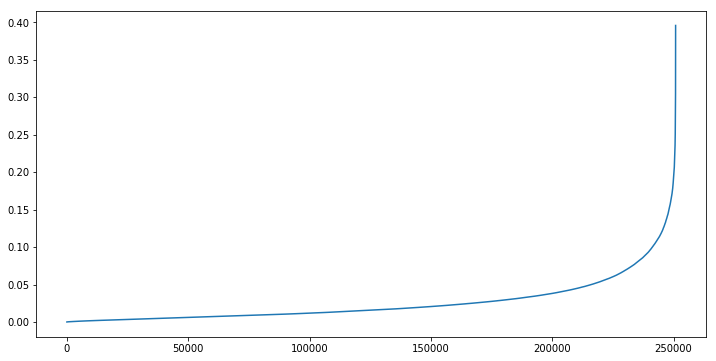

Mean check: 0.0262 

0    0.001922
1    0.004687
2    0.007362
3    0.010243
4    0.013709
5    0.018089
6    0.024026
7    0.032660
8    0.048235
9    0.100850
dtype: float64
disruption_flag
0    0.000000
1    0.000000
2    0.000000
3    0.000000
4    0.000000
5    0.000000
6    0.000000
7    0.000000
8    0.000000
9    0.263953
Name: disruption_flag, dtype: float64


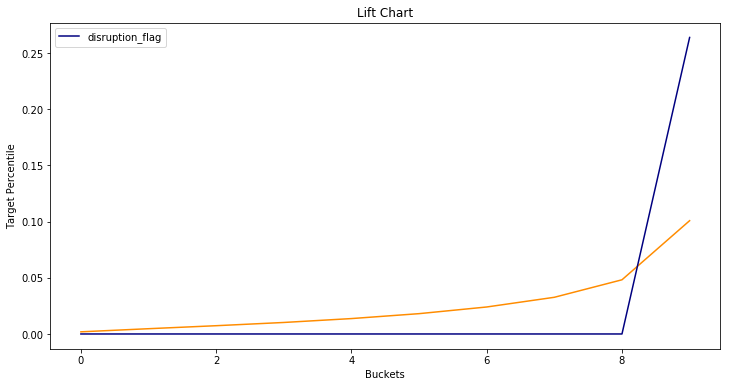

In [77]:
# test_predict_probs = test_predict_proba[:,1]
# print(test_predict_probs)
# test_predict_probs.type
# curve = pd.DataFrame(test_predict_probs).sort_values(by=[0],axis=1,ascending=False)
curve = np.sort(test_predict_probs)
plt.plot(curve)
print("Distribution of Probabilities:")
plt.show()

print("Mean check:",round(test_predict_probs.mean(),4),'\n')



def LiftCurve(actual, predicted, bins):
    actual_ranks = pd.qcut(actual.rank(method='first'),bins,labels=False)
    pred_ranks = pd.qcut(predicted.rank(method='first'),bins,labels=False)
    actual_percentiles = actual.groupby(actual_ranks).mean()
    pred_percentiles = predicted.groupby(pred_ranks).mean()
    
    plt.title('Lift Chart')
    plt.plot(pred_percentiles,color='darkorange')
    plt.plot(actual_percentiles,color='navy')
    plt.ylabel('Target Percentile')
    plt.xlabel('Buckets')
    plt.legend(loc='best') 
    
    print(pred_percentiles)
    print(actual_percentiles)
    
LiftCurve(test_target,test_predict_probs,10)
# extremely polarized, lift curve doesn't offer much

#### Assess feature importance:
 AirTime creates leakage, must be lagging indicator. 
I checked and it has blanks for cancellations, try CRSEstimatedTime.

                Importance
DayOfWeek           0.1334
Month               0.0978
FlightNum           0.0820
CRSDepTime          0.0813
CRSElapsedTime      0.0641
Carrier_MQ          0.0490
Quarter             0.0482
Distance            0.0421
Origin_LGA          0.0215
weekend_flag        0.0195
Dest_LGA            0.0191
Origin_BOS          0.0173
Dest_BOS            0.0138
DistanceGroup       0.0134
Dest_ORD            0.0099
Dest_EWR            0.0097
Origin_EWR          0.0084
Carrier_B6          0.0079
Carrier_DL          0.0072
Carrier_WN          0.0063


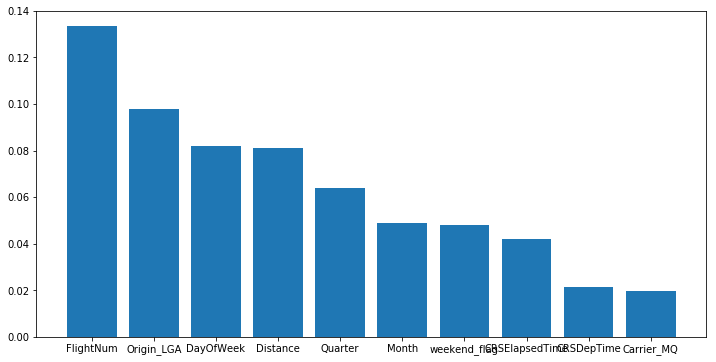

In [18]:
feature_importances = model.feature_importances_
importance_table = pd.DataFrame(feature_importances, index=train_features.columns, 
                          columns=["Importance"]).sort_values(by=['Importance'],ascending=False)
importance_table['Importance'] = round(importance_table['Importance'],4)
print(importance_table.head(20))

# ***visualize top 10 or more predictors
x_bar = set(importance_table.index[0:10])
y_bar = importance_table['Importance'][0:10]
ind = [x for x, _ in enumerate(x_bar)]
plt.rcParams['figure.figsize'] = [12, 6]

plt.bar(ind,y_bar)
plt.xticks(ind,x_bar)
plt.show()

<br/>

## III. MODEL PRICING SCHEME
Perfectly fluid pricing would be best for best price discrimination,
but I suggest 3 simple tiers, or more, because they're more interpretable.
Rank-order airline risk of disruption and select thresholds.
If the features of scored flights follow the same distributions as the training set 
then the thresholds should uphold the same accuracy as the training set.

(skip for now) consider weighing by number of passengers?

#### Score each dataset and output scored probabilities:
  if between 0 and a then Price I; <br/>
  if between a and b then Price II; <br/>
  if between b and 1 then Price III. <br/>

#### Selecting the Number of Tiers: 
   Tradeoff between complexity (for insured and customers) and price-risk discrimination

#### Selecting the Thresholds that Divide Tiers:
   Tradeoff between revenue from tiers (e.g., price of 9 dollars vs. 19 vs. 29) and profit.


In [4]:
def tiers(x):
    if x >= 0.02:
        return 'Group 3 (Highest Risk)'
    elif x >= 0.01:
        return 'Group 2 (Medium Risk)'
    elif x >= 0 :
        return 'Group 1 (Lowest Risk)'
#     elif x >= 0 :
#         return '*could add more tiers here and change thresholds*'
    else:
        return 'Missing'
    
# flight_test = flight_test.drop(['Pricing Tiers'],axis=1)
# flight_test = flight_test.reset_index()
    
flight_test['test_predict_probs'] = test_predict_probs
flight_test['Pricing Tiers'] = flight_test['test_predict_probs'].apply(tiers)
# flight_test['Pricing Tiers'] = test_predict_probs.iloc[:,0].apply(tiers)

print(flight_test['Pricing Tiers'].value_counts(),'\n')
print(flight_test['Pricing Tiers'].value_counts(normalize=True),'\n')
print("Sum Missing Tiers:",flight_test['Pricing Tiers'].isna().sum() 
      + len(flight_test[flight_test['Pricing Tiers']=='Missing']) )

# ***visualize normalized risk probabilities
flight_test.boxplot(column='test_predict_probs',by='Pricing Tiers')

NameError: name 'test_predict_probs' is not defined

### Create price assumptions and check tiers on holdout sample:

In [5]:
flight_cost = 500
flight_revenue = 19

flight_test['flight_revenue'] = flight_revenue
flight_test['disruption_cost'] =  flight_test['disruption_flag'] * flight_cost
flight_test['flight_revenue_minus_disruption_cost'] = flight_test['flight_revenue'] - flight_test['disruption_cost']

print("Count of Disruptions per Tier:",'\n',flight_test.groupby(['Pricing Tiers'])['disruption_flag'].sum(),'\n')
print("Revenue per Tier:",'\n',flight_test.groupby(['Pricing Tiers'])['flight_revenue'].sum(),'\n')
print("Cost of Disruptions per Tier:",'\n',flight_test.groupby(['Pricing Tiers'])['disruption_cost'].sum(),'\n')
print("Profit per Tier:",'\n',flight_test.groupby(['Pricing Tiers'])['flight_revenue_minus_disruption_cost'].sum(),'\n')
# plt.plot(flight_test.groupby(['Pricing Tiers'])['flight_revenue_minus_disruption_cost'].sum()


x_bar = set(flight_test['Pricing Tiers'])
y_bar = flight_test.groupby(['Pricing Tiers'])['flight_revenue_minus_disruption_cost'].sum()
ind = [x for x, _ in enumerate(x_bar)]

plt.bar(ind,y_bar)
plt.xticks(ind,x_bar)

print("Total Profit:",flight_test['flight_revenue_minus_disruption_cost'].sum(),'\n')

NameError: name 'flight_test' is not defined

<br/>

## IV. ESTIMATE OF DISTRIBUTION OF POTENTIAL PROFITS OR LOSSES
 We can use bootstrapping, MCMC, confidence intervals, or bayesian to create distributions.

#### Run bootstrap and report results for 10,000 simulations:
 Sum total marginal expected profit per flight scored, and then run bootstrap on that.

In [6]:
start = timeit.default_timer()

return_mean = pd.DataFrame()
prob_mean = pd.DataFrame()

for i in range(1,10000):
    fraction = 0.5
    n=round(len(flight_test)*fraction)
    boot = resample(flight_test, replace=True, n_samples=n, random_state=i)

    boot_prob = pd.Series(boot['test_predict_probs'].mean())
    boot_return = pd.Series(boot['flight_revenue_minus_disruption_cost'].sum()/fraction)

    prob_mean = prob_mean.append(boot_prob,ignore_index=True)
    return_mean = return_mean.append(boot_return,ignore_index=True)

    predict_pctl_1 = round(np.percentile(prob_mean,1),4)
    predict_pctl_5 = round(np.percentile(prob_mean,5),4)
    predict_pctl_50 = round(np.percentile(prob_mean,50),4)
    predict_pctl_95 = round(np.percentile(prob_mean,95),4)
    predict_pctl_99 = round(np.percentile(prob_mean,99),4)

    returns_pctl_1 = round(np.percentile(return_mean,1),4)
    returns_pctl_5 = round(np.percentile(return_mean,5),4)
    returns_pctl_50 = round(np.percentile(return_mean,50),4)
    returns_pctl_95 = round(np.percentile(return_mean,95),4)
    returns_pctl_99 = round(np.percentile(return_mean,99),4)

print("Predicted Disruption Probability Scenarios:",'\n',"1%:",predict_pctl_1," 5%:",predict_pctl_5
      ," 50%:",predict_pctl_50," 95%:",predict_pctl_95," 99%:",predict_pctl_99,'\n')
print("Predicted Return Scenarios:",'\n',"1%:",returns_pctl_1,"5%:",returns_pctl_5
      ,"50%:",returns_pctl_50,"95%:",returns_pctl_95,"99%:",returns_pctl_99,'\n')

end = timeit.default_timer()
print("Total time:",round(end - start,4), "seconds")

NameError: name 'flight_test' is not defined

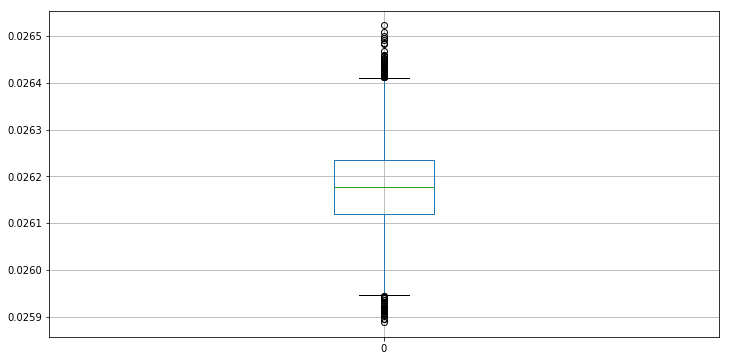

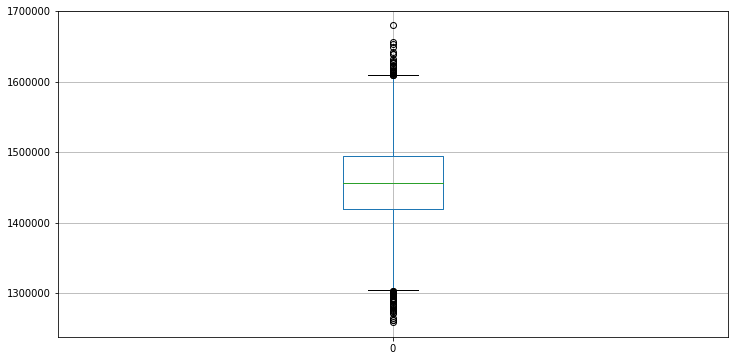

In [23]:
prob_mean.boxplot()
plt.show()
return_mean.boxplot()
plt.show()

<br/>

## V. SCORE HYPOTHETICAL DATASET

#### Found in hypothetical data? (and BTS data)
carrier - yes <br/>
origin - yes <br/>
dest - yes <br/>
flightnum - yes <br/>
year - yes <br/>
quarter - yes <br/>
month - yes <br/>
dayofweek - yes (need to derive) <br/>
dayofmonth - yes (need to derive) <br/>
CRSDepTime - yes (need to derive) <br/>
week of year - yes, if time (need to derive) <br/>
<br/>
distance - yes (need to derive) <br/>
distancegroup - yes (need to derive) <br/>
CRSelapsed - yes (need to derive) <br/>
<br/>
Don't need: <br/>
airtime - can't use, need CRSelapsed time between airports (need to derive) <br/>
actualelapsedtime - unneeded (lagging indicator) <br/>
deptime - yes <br/>
<br/>
Don't need direct vs. non-direct flag because BTS is only single-leg flights. <br/>
Distance should have one single value for each two airports. <br/>

#### Import hypothetical data:

In [7]:
hypo = pd.read_csv(r"cancellations/hypothetical flight data.csv")

In [8]:
# hypo.head()
departure_date = hypo['departure_date'].apply(lambda x: datetime.strptime(x,'%m/%d/%y'))
hypo['Quarter'] = departure_date.dt.quarter
hypo['Month'] = departure_date.dt.month
hypo['Week'] = departure_date.dt.week
Weekday_0 = departure_date.dt.weekday
hypo['DayOfWeek'] = Weekday_0 + 1
hypo['DayofMonth'] = departure_date.apply(lambda x: datetime.strftime(x,'%d'))

# ADD WEEKEND FLAG
def weekend(x):
    if x >= 6:
        return 1
    else: 
        return 0
    
hypo['weekend_flag'] = hypo['DayOfWeek'].apply(weekend)
hypo['weekend_flag'].head()

0    0
1    1
2    0
3    1
4    0
Name: weekend_flag, dtype: int64

#### Calculate distance tables between all airport pairs:
Using mean as aggregation but only one value sohuld be returned for each pair.

In [9]:
distance_table = pd.DataFrame(flight_data.groupby(['Origin','Dest'])['Distance'].mean().round())
distance_group = pd.DataFrame(flight_data.groupby(['Origin','Dest'])['DistanceGroup'].mean().round())
elapsed_table = pd.DataFrame(flight_data.groupby(['Origin','Dest'])['CRSElapsedTime'].mean().round())

print("Hypo Shape:",hypo.shape)
hypo_join1 = pd.merge(hypo,distance_table,how='left',on=['Origin','Dest'])
# hypo_join1.head()
hypo_join2 = pd.merge(hypo_join1,distance_group,how='left',on=['Origin','Dest'])
# hypo_join2.head()
hypo_join3 = pd.merge(hypo_join2,elapsed_table,how='left',on=['Origin','Dest'])
hypo_join3.head()

hypo_final = hypo_join3

# print("Hypo_join2 Shape:",hypo_join2.shape)

NameError: name 'flight_data' is not defined

#### Convert departure time into datetime format:

In [10]:
departure_time = hypo_final['departure_time'].apply(lambda x: datetime.strptime(x,'%H:%M:%S'))
print(departure_time.head())

hypo_final['CRSDepTime'] = departure_time.dt.strftime('%M%S').astype(np.int64)


hypo_final['sin_CRSDepTime'] = hypo_final['CRSDepTime'].apply(lambda x: np.sin(x))
hypo_final['sin_CRSDepTime'].sample(10)

hypo_final['sin_CRSDepTime'].isnull().sum()
hypo_final['disruption_flag'] = 0


hypo_final.head()

NameError: name 'hypo_final' is not defined

#### Prepare hypothetical data for model scoring:

disruption_flag
random
Dest_AKN
Dest_ITH
Origin_ITH
2589
[[0.92768647 0.07231353]
 [0.98142238 0.01857762]
 [0.98707632 0.01292368]
 [0.95605162 0.04394838]
 [0.9745024  0.0254976 ]
 [0.96956463 0.03043537]
 [0.96575691 0.03424309]
 [0.9821599  0.0178401 ]
 [0.99328041 0.00671959]
 [0.9728762  0.0271238 ]]


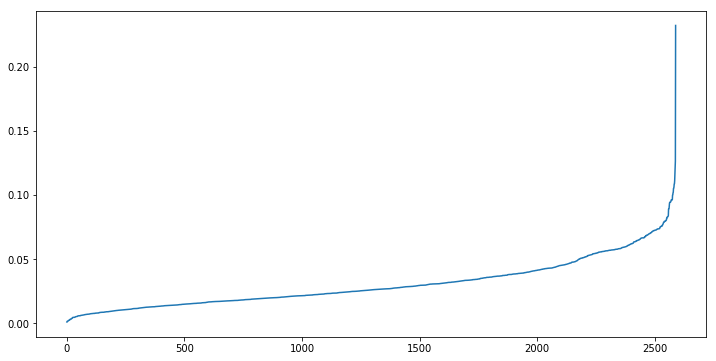

In [29]:
hypo_final_features = hypo_final[features]
hypo_final_impute = DataFrameImputer().fit_transform(hypo_final_features)
hypo_length = len(hypo_final_impute)
hypo_final_concat = pd.concat([hypo_final_impute,flight_train])

hypo_dummies = pd.get_dummies(hypo_final_concat)
hypo_final_cut = hypo_dummies.iloc[0:hypo_length]

remove_cols = pd.Series()
for i in hypo_final_cut.columns:
    if not {i}.issubset(test_features.columns):
        print(i)
        j = pd.Series(i)
        remove_cols = remove_cols.append(j,ignore_index=True)
remove_cols.head()

# hypo_final_score = hypo_final_cut.drop(['disruption_flag','random'
#                                               ,'Dest_AKN','Origin_AKN','Origin_BGM'
#                                               ],axis=1)

hypo_final_score = hypo_final_cut.drop(remove_cols,axis=1)


hypo_final_cut = hypo_dummies.drop(remove_cols,axis=1)

hypo_predict = model.predict_proba(hypo_final_score)
print(len(hypo_predict))
print(hypo_predict[1000:1010])
plt.plot(np.sort(hypo_predict[:,1]))

<br/>

#### FUNCTION TO OUTPUT NEW PRICES: Set x equal to new dataset

In [30]:
def score_hypo(x = hypo_final_score):
    global hypo_predict2
    data = model.predict_proba(x)
    hypo_predict = pd.DataFrame(data)

#### Generate new prices and pricing tiers from earlier function:

High Risk Price (2% disruption chance or greater): 29 dollars
<br/>
Medium Risk Price (2% disruption chance or greater): 19 dollars
<br/>
Low Risk Price (2% disruption chance or greater): 9 dollars


Group 3 (Highest Risk)    1380
Group 2 (Medium Risk)     1004
Group 1 (Lowest Risk)      205
Name: Pricing Tiers, dtype: int64 

Group 3 (Highest Risk)    0.533024
Group 2 (Medium Risk)     0.387795
Group 1 (Lowest Risk)     0.079181
Name: Pricing Tiers, dtype: float64 

Sum Missing Tiers: 0


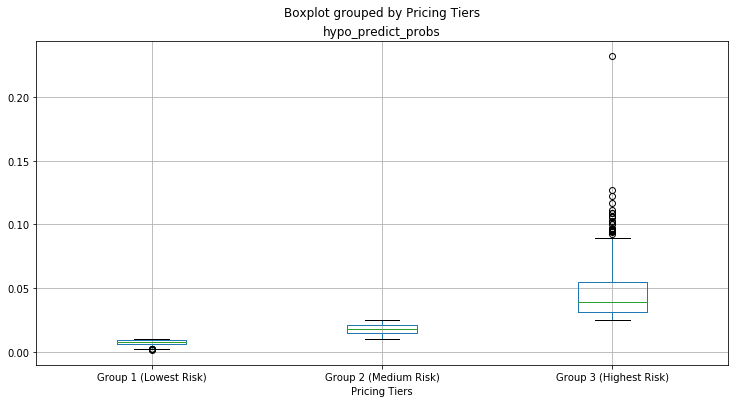

In [55]:

def prices(x):
    if x >= 0.02:
        return 29
    elif x >= 0.01:
        return 19
    elif x >= 0 :
        return 9
#     elif x >= 0 :
#         return '*could add more tiers here and change thresholds*'
    else:
        return 'Missing'
    
hypo_predict_probs = pd.Series(hypo_predict[:,1])
hypo['hypo_predict_probs'] = hypo_predict_probs
hypo['Pricing Tiers'] = hypo['hypo_predict_probs'].apply(tiers)
hypo['Price'] = hypo['hypo_predict_probs'].apply(prices)

print(hypo['Pricing Tiers'].value_counts(),'\n')
print(hypo['Pricing Tiers'].value_counts(normalize=True),'\n')
print("Sum Missing Tiers:",hypo['Pricing Tiers'].isna().sum() 
      + len(hypo[hypo['Pricing Tiers']=='Missing']) )

# ***visualize normalized risk probabilities
hypo.boxplot(column='hypo_predict_probs',by='Pricing Tiers')

<br/>

#### Generate Revenue, Predicted Cost, and Predicted Profit by Pricing Tier:

In [1]:
flight_cost = 500
# flight_revenue = 19

# hypo['flight_revenue'] = flight_revenue
hypo['flight_revenue'] = hypo['Price']
hypo['disruption_cost'] =  hypo['hypo_predict_probs'] * flight_cost
hypo['flight_revenue_minus_disruption_cost'] = hypo['flight_revenue'] - hypo['disruption_cost']

# print("Count of Disruptions per Tier:",'\n',hypo.groupby(['Pricing Tiers'])['departure_date'].count(),'\n')
print("Count of Disruptions per Tier:",'\n',hypo['Pricing Tiers'].value_counts(),'\n')
print("Count of Disruptions per Tier:",'\n',hypo['Pricing Tiers'].value_counts(normalize=True),'\n')

# print("Count of Disruptions per Tier:",'\n',hypo.groupby(['Pricing Tiers'])['departure_date'].count(),'\n')

print("Revenue per Tier:",'\n',hypo.groupby(['Pricing Tiers'])['flight_revenue'].sum(),'\n')
print("Predicted Cost of Disruptions per Tier:",'\n',hypo.groupby(['Pricing Tiers'])['disruption_cost'].sum(),'\n')
print("Predicted Profit per Tier:",'\n',hypo.groupby(['Pricing Tiers'])['flight_revenue_minus_disruption_cost'].sum(),'\n')
# plt.plot(flight_test.groupby(['Pricing Tiers'])['flight_revenue_minus_disruption_cost'].sum()


# x_bar = set(hypo['Pricing Tiers'])
x_bar = ['Group 1 (Lowest Risk)','Group 2 (Medium Risk)','Group 3 (Highest Risk)']
y_bar = hypo.groupby(['Pricing Tiers'])['flight_revenue_minus_disruption_cost'].sum()
ind = [x for x, _ in enumerate(x_bar)]

plt.title('Predicted Total Profit by Pricing Tier')
plt.bar(ind,y_bar)
plt.xticks(ind,x_bar)

print("Total Revenue:",round(hypo['flight_revenue_cost'].sum(),2),'\n')
print("Predicted Total Cost:",round(hypo['disruption_cost'].sum(),2),'\n')
print("Predicted Total Profit:",round(hypo['flight_revenue_minus_disruption_cost'].sum(),2),'\n')

NameError: name 'hypo' is not defined